In [77]:
from time import time
import numpy as np
import keras.backend as K
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt

import tensorflow_addons as tfa
import plotting_funcs as pf
import clustering_model as cm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

In [78]:
X = np.load('../npy_files/features_All32.npy')
y = np.load('../npy_files/labels_All32.npy')
types = np.load('../npy_files/celltypes_All32.npy')
y_letter = np.array([well[:1] for well in y])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labs = le.fit_transform(y)
labs_by_letter = le.fit_transform(y_letter)
print(len(X),len(y))
X_train, y_train = X, labs
X_train.shape

4600 4600


(4600, 32, 5)

In [79]:
# #cut area column
# x_cut = np.delete(X, 2, 2)
# X_train = x_cut.copy()
# X_train.shape

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_train.shape[1]

32

In [81]:
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape,LSTM,RepeatVector,Dense,TimeDistributed, \
Conv1D,LeakyReLU,MaxPool1D,Bidirectional,UpSampling2D,Input
from keras.models import Model,Sequential
def temporal_autoencoder(input_dim, timesteps, n_filters=50, kernel_size=10, strides=1, pool_size=10, n_units=[50, 1]):
    """
    Temporal Autoencoder (TAE) model with Convolutional and BiLSTM layers.

    # Arguments
        input_dim: input dimension
        timesteps: number of timesteps (can be None for variable length sequences)
        n_filters: number of filters in convolutional layer
        kernel_size: size of kernel in convolutional layer
        strides: strides in convolutional layer
        pool_size: pooling size in max pooling layer, must divide time series length
        n_units: numbers of units in the two BiLSTM layers

    # Return
        (ae_model, encoder_model, decoder_model): AE, encoder and decoder models
    """
    assert(timesteps % pool_size == 0)

    # Input
    x = Input(shape=(timesteps, input_dim), name='input_seq')

    # Encoder
    encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
    #encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    encoded = LeakyReLU()(encoded)
    encoded = MaxPool1D(pool_size)(encoded)
    encoded = Bidirectional(LSTM(n_units[0], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Bidirectional(LSTM(n_units[1], return_sequences=True), merge_mode='sum')(encoded)
    encoded = LeakyReLU(name='latent')(encoded)

    # Decoder
    decoded = Reshape((-1, 1, n_units[1]), name='reshape')(encoded)
    decoded = UpSampling2D((pool_size, 1), name='upsampling')(decoded)  #decoded = UpSampling1D(pool_size, name='upsampling')(decoded)
    decoded = Conv2DTranspose(input_dim, (kernel_size, 1), padding='same', name='conv2dtranspose')(decoded)
    output = Reshape((-1, input_dim), name='output_seq')(decoded)  #output = Conv1D(1, kernel_size, strides=strides, padding='same', activation='linear', name='output_seq')(decoded)

    # AE model
    autoencoder = Model(inputs=x, outputs=output, name='AE')

    # Encoder model
    encoder = Model(inputs=x, outputs=encoded, name='encoder')

    # Create input for decoder model
    encoded_input = Input(shape=(timesteps // pool_size, n_units[1]), name='decoder_input')

    # Internal layers in decoder
    decoded = autoencoder.get_layer('reshape')(encoded_input)
    decoded = autoencoder.get_layer('upsampling')(decoded)
    decoded = autoencoder.get_layer('conv2dtranspose')(decoded)
    decoder_output = autoencoder.get_layer('output_seq')(decoded)

    # Decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_output, name='decoder')

    return autoencoder, encoder, decoder

In [86]:
#model params
input_dim = X_train.shape[-1]
timesteps = X_train.shape[-2]
n_filters = 2000
kernel_size = 32
strides = 1
pool_size = 8
n_units = [100,4]

optimizer='adam'
loss = 'mse'
loss = tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss")
epochs=30
batch_size=64
save_dir='results/tmp'
verbose=1

In [87]:
autoencoder,encoder,decoder = temporal_autoencoder(input_dim,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
autoencoder.compile(optimizer=optimizer, loss=loss)

In [88]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 32, 5)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 32, 2000)          322000    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32, 2000)          0         
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 4, 2000)          0         
 g1D)                                                            
                                                                 
 bidirectional_28 (Bidirecti  (None, 4, 100)           1680800   
 onal)                                                           
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 4, 100)            0        

In [89]:
t0 = time()
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
print('Pretraining time: ', time() - t0)

Epoch 1/30
72/72 [==============================] - 28s 134ms/step - loss: 0.2390
Epoch 2/30
72/72 [==============================] - 10s 140ms/step - loss: 0.1764
Epoch 3/30
72/72 [==============================] - 10s 140ms/step - loss: 0.1593
Epoch 4/30
72/72 [==============================] - 10s 140ms/step - loss: 0.1508
Epoch 5/30
72/72 [==============================] - 9s 130ms/step - loss: 0.1459
Epoch 6/30
72/72 [==============================] - 10s 136ms/step - loss: 0.1438
Epoch 7/30
72/72 [==============================] - 11s 151ms/step - loss: 0.1405
Epoch 8/30
72/72 [==============================] - 10s 138ms/step - loss: 0.1398
Epoch 9/30
72/72 [==============================] - 11s 155ms/step - loss: 0.1398
Epoch 10/30
72/72 [==============================] - 11s 146ms/step - loss: 0.1376
Epoch 11/30
72/72 [==============================] - 10s 138ms/step - loss: 0.1373
Epoch 12/30
72/72 [==============================] - 10s 137ms/step - loss: 0.1366
Epoch 13/30
72

(10, 32, 5)
1/1 [==============================] - 0s 63ms/step


/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


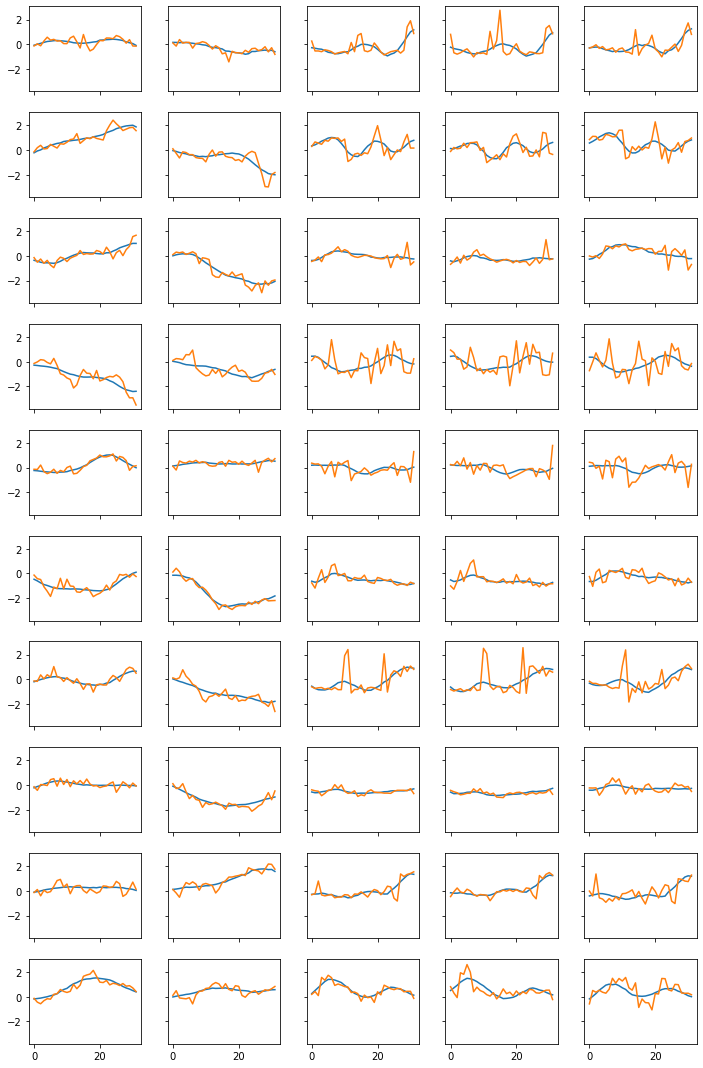

In [93]:
size = 10
rand_idx = np.random.choice(X_train.shape[0], size, replace=False)

orig_vec = X_train[rand_idx,:,:]
print(orig_vec.shape)

pred_vec = autoencoder.predict(orig_vec)

pf.plot_autoencoder_by_time(orig_vec,pred_vec)

/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


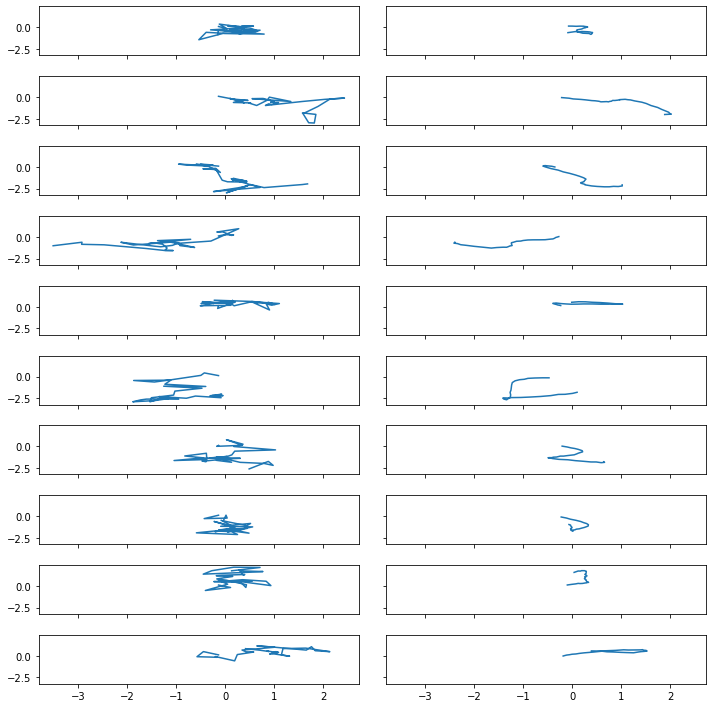

In [94]:
pf.plot_representatives([orig_vec,pred_vec])

In [74]:
autoencoder,encoder,decoder = temporal_autoencoder(input_dim,timesteps,n_filters,kernel_size,strides,pool_size,n_units)
autoencoder.compile(optimizer=optimizer, loss=loss)

In [75]:
t0 = time()
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
print('Pretraining time: ', time() - t0)

Epoch 1/30
72/72 [==============================] - 15s 117ms/step - loss: 0.6081
Epoch 2/30
72/72 [==============================] - 9s 120ms/step - loss: 0.4434
Epoch 3/30
72/72 [==============================] - 8s 115ms/step - loss: 0.4037
Epoch 4/30
72/72 [==============================] - 8s 117ms/step - loss: 0.3826
Epoch 5/30
72/72 [==============================] - 9s 127ms/step - loss: 0.3669
Epoch 6/30
72/72 [==============================] - 9s 123ms/step - loss: 0.3561
Epoch 7/30
72/72 [==============================] - 9s 121ms/step - loss: 0.3512
Epoch 8/30
72/72 [==============================] - 9s 131ms/step - loss: 0.3542
Epoch 9/30
72/72 [==============================] - 9s 122ms/step - loss: 0.3449
Epoch 10/30
72/72 [==============================] - 9s 120ms/step - loss: 0.3398
Epoch 11/30
72/72 [==============================] - 8s 116ms/step - loss: 0.3385
Epoch 12/30
72/72 [==============================] - 9s 125ms/step - loss: 0.3369
Epoch 13/30
72/72 [=====

(10, 32, 5)
1/1 [==============================] - 2s 2s/step


/Users/amosavni/university/DeepLearningWorkshop/deepcell_mod/DL-WORKSHOP/Clustering/plotting_funcs.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


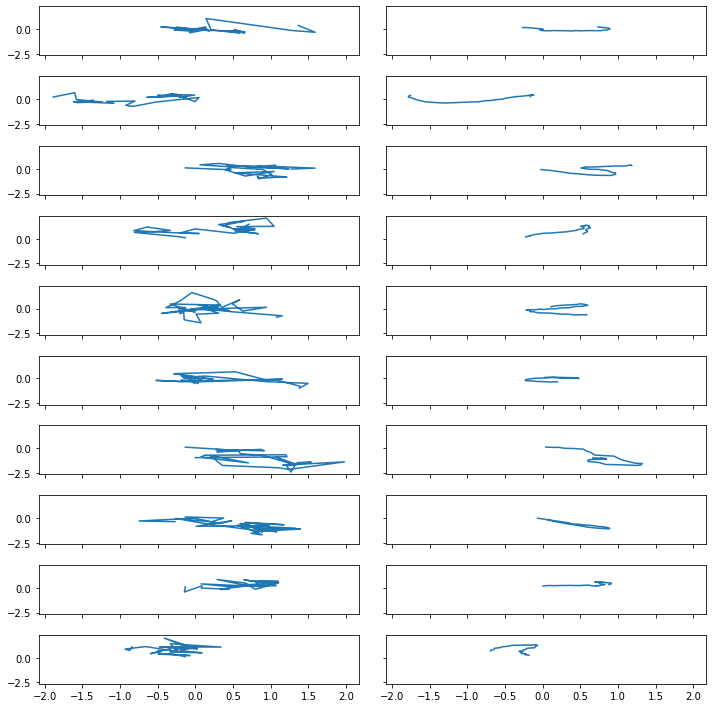

In [76]:
orig_vec = X_train[rand_idx,:,:]
print(orig_vec.shape)

pred_vec = autoencoder.predict(orig_vec)
pf.plot_representatives([orig_vec,pred_vec])

In [102]:
latent = encoder.predict(X_train)

144/144 [==============================] - 2s 12ms/step


In [106]:
latent = latent.reshape(latent.shape[0],latent.shape[1]*latent.shape[2])

In [107]:
labs_by_type = le.fit_transform(types)

In [113]:
import config
def plot_clustering(latent, clusters):

    clusters = clusters[:latent.shape[0]] # because of weird batch_size

    colors = [config.color_options[int(i)] for i in clusters]

    latent_pca = TruncatedSVD(n_components=2).fit_transform(latent)
    latent_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(latent)

    fig, axs = plt.subplots(2, figsize=(10,20),sharey=False,sharex=False)

    axs[0].scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors, marker='*', linewidths=0)
    axs[0].set_title('PCA')

    axs[1].scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axs[1].set_title('tSNE')

    fig.show()

/var/folders/s6/khx_n6gj1fgfgkzsbv62f8sw0000gn/T/ipykernel_69650/3027661819.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


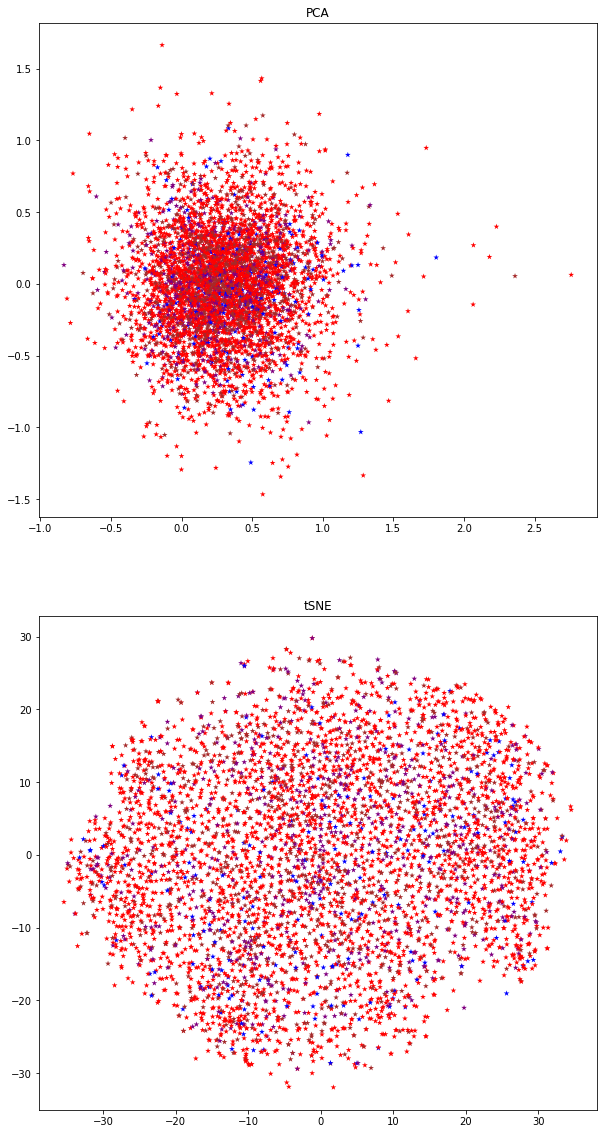

In [114]:
plot_clustering(latent,labs_by_letter)